### 

`fastq-dump`

https://www.biostars.org/p/222122/


In [1]:
# !wget ftp.sra.ebi.ac.uk/vol1/fastq/SRR117/072/SRR11711272/SRR11711272_1.fastq.gz

In [2]:
# ls -lh GSE79044_RNAseq/fastq

In [3]:
# cat GSE79044_RNAseq/fastq/download.out

In [4]:
# srr = open('GSE79044_RNAseq/SRR_Acc_List.txt')

# for s in srr.readlines():
#     s = s.replace('\n','')
#     n = s[-1]
#     cmd=f'rsync -av rsync://ftp.sra.ebi.ac.uk/vol1/fastq/SRR321/00{n}/{s}/{s}.fastq.gz .'
#     print(cmd)

### 

In [55]:
import os
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
from glob import glob

from pydeseq2.preprocessing import deseq2_norm

In [56]:
import sys

In [57]:
sys.path.append('../scripts')

from util import find_top

In [58]:
import blitzgsea as blitz

import upsetplot as up

from matplotlib import pyplot as plt

In [59]:
import upsetplot as up

In [60]:
import pypage
import upsetplot as up

In [108]:
delta_exp = {}

for cell_type in ['Macrophage','Monocyte','Neutrophil']:
    for end_time in [#'3h',#'6h',
                     # '12h','24h','48h','96h',
                     '120h'
                     ]:
        delta_exp[
            f'{cell_type}_{end_time}'
        ]=pd.read_csv(
            f'exp/res_{cell_type}Time_{end_time}_vs_0h_delta_exp_table.txt',
            sep='\t'
        ).set_index(['gene_id','gene_name'])

In [109]:
# ls exp/*_vs_0h_delta_exp.txt

In [110]:
delta_exp.update({
    "decitabine+rg3039":pd.read_csv(
    #     '../DAC-rg3039/RNA-seq/exp/res_decitabine.rg3039_delta_exp_table.txt',sep='\t'
        '../DAC-rg3039/RNA-seq/exp/res_comb_vs_dmso_delta_exp_table.txt',sep='\t'
    ).set_index(['gene_id','gene_name']),
    "decitabine":pd.read_csv(
        '../DAC-rg3039/RNA-seq/exp/res_decitabine_vs_dmso_delta_exp_table.txt',sep='\t'
    ).set_index(['gene_id','gene_name']),
    "rg3039":pd.read_csv(
        '../DAC-rg3039/RNA-seq/exp/res_rg3039_vs_dmso_delta_exp_table.txt',sep='\t'
    ).set_index(['gene_id','gene_name'])
})

In [111]:
list(
    delta_exp.keys()
)

['Macrophage_120h',
 'Monocyte_120h',
 'Neutrophil_120h',
 'decitabine+rg3039',
 'decitabine',
 'rg3039']

In [112]:
delta_exp_df = pd.concat(delta_exp,axis=1)

In [113]:
delta_exp.keys()

dict_keys(['Macrophage_120h', 'Monocyte_120h', 'Neutrophil_120h', 'decitabine+rg3039', 'decitabine', 'rg3039'])

In [107]:
# pd.concat(dict([
#     (cond,delta_exp_df[cond]['log2FoldChange'])
#     for cond in delta_exp.keys()
# ]),axis=1).to_csv('delta_exp_log2FoldChange_table.txt',sep='\t')

___

In [81]:
delta_exp_genes = {}

for delta_name in delta_exp.keys():
    print(f'\033[1m{delta_name}\033[0m')
    # delta_exp_genes[delta_name] = {}
    delta_exp_genes[f'{delta_name}_up'], delta_exp_genes[f'{delta_name}_down'] = [
        set(df.index.to_frame().gene_name.to_list()) for df in 
        find_top(delta_exp[delta_name],'log2FoldChange',1,'pvalue',0.05)
    ]

Macrophage_120h
up:  3494
down: 3223
Monocyte_120h
up:  1518
down: 1141
Neutrophil_120h
up:  3123
down: 3781
decitabine+rg3039
up:  2156
down: 1487
decitabine
up:  1150
down: 265
rg3039
up:  1160
down: 820


In [82]:
data = up.from_contents(delta_exp_genes)

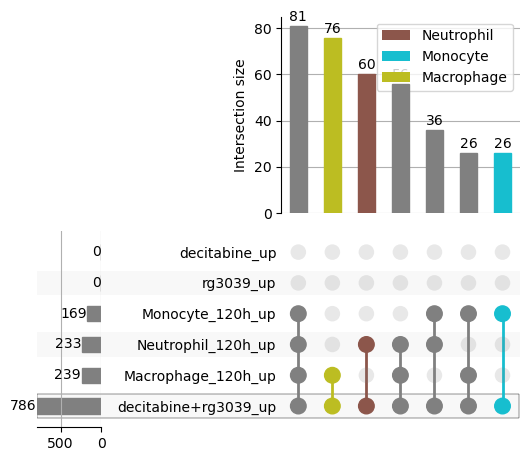

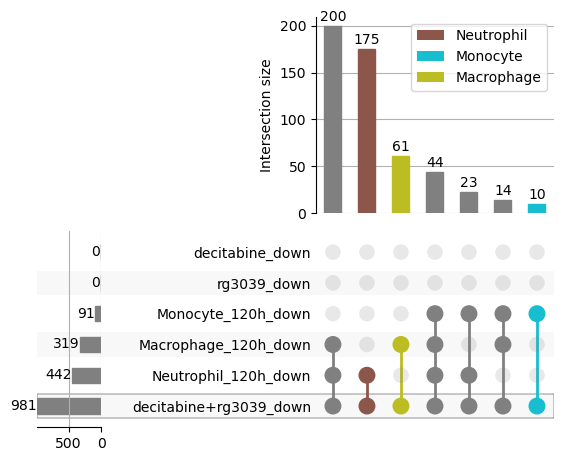

In [83]:
for side in ['up','down']:

    d = up.from_contents({k:v for (k,v) in delta_exp_genes.items() if side in k})

    res = up.query(d, 
                      present=f'decitabine+rg3039_{side}',
                      absent=[f'decitabine_{side}',f'rg3039_{side}']
                     )

    upset = up.UpSet(
        res.data, 
        # data, 
        sort_by='cardinality',
        subset_size="count",
        # orientation=
        facecolor="gray",
        min_degree=2,
        show_counts=True,
        # max_degree=2
    )

    upset.style_subsets(
        present=[f'Neutrophil_120h_{side}'],
        absent=[f'Monocyte_120h_{side}',f'Macrophage_120h_{side}'],
        min_degree=2, label="Neutrophil",facecolor="tab:brown")
    upset.style_subsets(
        present=[f'Monocyte_120h_{side}'],
        absent=[f'Neutrophil_120h_{side}',f'Macrophage_120h_{side}'],
        min_degree=2, label="Monocyte",facecolor="tab:cyan")
    upset.style_subsets(
        present=[f'Macrophage_120h_{side}'],
        absent=[f'Neutrophil_120h_{side}',f'Monocyte_120h_{side}'],
        min_degree=2, label="Macrophage",facecolor="tab:olive")

    # upset.style_subsets(present=['Monocyte_120h_down'],     min_degree=2, label='Monocyte',facecolor="blue")#,hatch="xx", edgecolor="m")
    # upset.style_subsets(present=['Macrophage_120h_down'],   min_degree=2, label='Macrophage',facecolor="blue")

    upset.style_categories(f"decitabine+rg3039_{side}", shading_edgecolor="black", shading_linewidth=.3)

    upset.plot()
    plt.savefig(f'upsetplot_{side}.pdf')
    plt.show()

In [182]:
ol_genesets = {}

for side in ['up','down']:
    ol_genesets[f'Neutrophil_120h_{side}'] = list(set(up.query(
            data,
            present=[f'decitabine+rg3039_{side}',f'Neutrophil_120h_{side}'],
            absent=[f'decitabine_{side}',f'rg3039_{side}',
                    f'Macrophage_120h_{side}',f'Monocyte_120h_{side}']
        ).data['id']))

    ol_genesets[f'Monocyte_120h_{side}'] = list(set(up.query(
            data,
            present=[f'decitabine+rg3039_{side}',f'Monocyte_120h_{side}'],
            absent=[f'decitabine_{side}',f'rg3039_{side}',
                    f'Macrophage_120h_{side}',f'Neutrophil_120h_{side}']
        ).data['id']))

    ol_genesets[f'Macrophage_120h_{side}'] = list(set(up.query(
            data,
            present=[f'decitabine+rg3039_{side}',f'Macrophage_120h_{side}'],
            absent=[f'decitabine_{side}',f'rg3039_{side}',
                    f'Monocyte_120h_{side}',f'Neutrophil_120h_{side}']
        ).data['id']))

In [187]:
ol_genesets[f'Neutrophil_120h_up']

['ZP3',
 'ISG15',
 'AL137186.2',
 'TMEM120A',
 'PIAS3',
 'TAP1',
 'PRELP',
 'LTB',
 'ZC2HC1A',
 'DGKK',
 'VENTX',
 'LINC02452',
 'PPP2R5B',
 'GPR35',
 'AC138932.3',
 'UPB1',
 'AC092944.1',
 'AC064805.2',
 'G6PD',
 'TNFSF9',
 'ABTB2',
 'EPHB3',
 'HCFC2',
 'H1-10',
 'SPSB2',
 'PROCA1',
 'FGD3',
 'IFITM2',
 'LTA',
 'MYO5A',
 'DYNLT3',
 'MYADM',
 'APCDD1',
 'CLEC4D',
 'SGMS1-AS1',
 'C15orf62',
 'BIRC7',
 'AC130371.2',
 'AL137018.1',
 'ZNF211',
 'AC073957.3',
 'PTPN22',
 'CSF2RA',
 'AC002519.1',
 'NUAK2',
 'AC068473.3',
 'DIO2',
 'ZNF876P',
 'PARP10',
 'AP000355.1',
 'FAM106A',
 'FAM227A',
 'RIC8A',
 'AL031733.2',
 'CAPN3',
 'CCR3',
 'PCDHGA5',
 'N4BP3',
 'AC023157.2',
 'GLCCI1']

In [600]:
# mkdir onePAGE

In [601]:
for k,v in ol_genesets.items():
    pd.Series(v).to_csv(f'onePAGE/geneset_{k}.txt',index=False,header=None)    

In [602]:
[(k, len(v))for k,v in ol_genesets.items()]

[('Neutrophil_120h_up', 60),
 ('Monocyte_120h_up', 26),
 ('Macrophage_120h_up', 76),
 ('Neutrophil_120h_down', 175),
 ('Monocyte_120h_down', 10),
 ('Macrophage_120h_down', 61)]

In [1]:
import os

In [2]:
os.environ['TEISERDIR']

'/data_gilbert/home/aarab/tools/TEISERv1.1/'

In [634]:
RNA_seq_dir = '../DAC-rg3039/RNA-seq/exp'

conditions = ['comb_vs_dmso','decitabine_vs_dmso','rg3039_vs_dmso','decitabine.rg3039']

for geneset_name in ol_genesets.keys():
    if 'Neutrophil' in geneset_name:

        for condition in conditions:
            pd.read_csv(
                f'{RNA_seq_dir}/res_{condition}_delta_exp.txt',sep='\t'
            ).drop_duplicates('gene_name').to_csv(
                f'onePAGE/res_{condition}_delta_exp.c.txt',sep='\t',index=False
            )

            print(condition,geneset_name)

            !bash ../scripts/onePAGE.sh \
                onePAGE \
                res_{condition}_delta_exp.c.txt \
                geneset_{geneset_name} &> /dev/null

            !rm onePAGE/res_{condition}_delta_exp.c.txt
            !rm onePAGE/res_{condition}_delta_exp.c_onePAGE_geneset_{geneset_name}.summary.pdf            

comb_vs_dmso Neutrophil_120h_up
decitabine_vs_dmso Neutrophil_120h_up
rg3039_vs_dmso Neutrophil_120h_up
decitabine.rg3039 Neutrophil_120h_up
comb_vs_dmso Neutrophil_120h_down
decitabine_vs_dmso Neutrophil_120h_down
rg3039_vs_dmso Neutrophil_120h_down
decitabine.rg3039 Neutrophil_120h_down


In [605]:
comb = pd.read_csv(
    '../DAC-rg3039/RNA-seq/exp/res_decitabine.rg3039_delta_exp_table.txt',sep='\t'
).set_index(['gene_id','gene_name'])

pd.Series([
    gene for df in find_top(comb,'log2FoldChange',1,'pvalue',0.05)
    for gene in set(df.index.to_frame().gene_name.to_list()) 
]).to_csv(f'onePAGE/geneset_decitabine.rg3039.txt',index=False,header=None)

up:  537
down: 654


In [606]:
df,_ = find_top(comb,'log2FoldChange',1,'pvalue',0.05)

pd.Series([
    gene for gene in set(df.index.to_frame().gene_name.to_list()) 
]).to_csv(f'onePAGE/geneset_decitabine.rg3039_up.txt',index=False,header=None)

_,df = find_top(comb,'log2FoldChange',1,'pvalue',0.05)

pd.Series([
    gene for gene in set(df.index.to_frame().gene_name.to_list()) 
]).to_csv(f'onePAGE/geneset_decitabine.rg3039_down.txt',index=False,header=None)

up:  537
down: 654
up:  537
down: 654


In [630]:
RNA_seq_dir = 'exp'

geneset_name = 'Neutrophil_120h_down'

for cell_type in [#'Macrophage','Monocyte',
                  'Neutrophil']:
    for end_time in ['3h','6h',
                     '12h','24h','48h','96h',
                     '120h'
                     ]:
        condition = f'{cell_type}Time_{end_time}_vs_0h'

        pd.read_csv(
            f'{RNA_seq_dir}/res_{condition}_delta_exp.txt',sep='\t'
        ).drop_duplicates('gene_name').to_csv(
            f'onePAGE/res_{condition}_delta_exp.c.txt',sep='\t',index=False
        )

        print(condition,geneset_name)
        
        !bash ../scripts/onePAGE.sh \
            onePAGE \
            res_{condition}_delta_exp.c.txt \
            geneset_{geneset_name} &> /dev/null
        
        !rm onePAGE/res_{condition}_delta_exp.c.txt
        !rm onePAGE/res_{condition}_delta_exp.c_onePAGE_geneset_{geneset_name}.summary.pdf

NeutrophilTime_3h_vs_0h Neutrophil_120h_down
NeutrophilTime_6h_vs_0h Neutrophil_120h_down
NeutrophilTime_12h_vs_0h Neutrophil_120h_down
NeutrophilTime_24h_vs_0h Neutrophil_120h_down
NeutrophilTime_48h_vs_0h Neutrophil_120h_down
NeutrophilTime_96h_vs_0h Neutrophil_120h_down
NeutrophilTime_120h_vs_0h Neutrophil_120h_down


In [3]:
import sys

In [4]:
sys.path.append('/data_gilbert/home/aarab/tools/pager/')

In [5]:
from onePAGE import merge_onePAGE_results

In [6]:
from glob import glob

In [49]:
geneset = 'Neutrophil_120h_down'

onePAGE_path = 'onePAGE'
onePAGE_name = f'drug_treatment_geneset_{geneset}'

matrix,summary = merge_onePAGE_results(
    glob(f'onePAGE/*vs_dmso_*onePAGE*{geneset}/'),
    merge_by='exp',
    fix_bins=True,
    clean_geneset_names = ['_vs_dmso_delta_exp.c','res_','Time']
)

summary['index']=pd.Categorical(summary['index'],categories=['decitabine','rg3039','comb'])
summary = summary.sort_values(['index'],ascending=False)
matrix['MOTIF']=pd.Categorical(matrix['MOTIF'],categories=['decitabine','rg3039','comb'])
matrix = matrix.sort_values(['MOTIF'],ascending=False)

matrix.to_csv(f'{onePAGE_path}/{onePAGE_name}.txt.matrix',sep='\t',header=True,index=False)
summary.to_csv(f'{onePAGE_path}/{onePAGE_name}.txt.summary',sep='\t',header=True,index=False)

In [50]:
!bash ../scripts/onePAGE_draw_matrix.sh {onePAGE_path} {onePAGE_name} & > /dev/null

In [52]:
cell_type = 'Neutrophil'

geneset = 'Neutrophil_120h_down'

onePAGE_path = 'onePAGE'
onePAGE_name = f'{cell_type}_geneset_{geneset}'


matrix,summary = merge_onePAGE_results(
    glob(f'onePAGE/*{cell_type}*_0h_delta_exp*onePAGE*{geneset}/'),
    merge_by='exp',
    fix_bins=True,
    clean_geneset_names = ['_vs_0h_delta_exp.c','res_','Time']
)

summary['time']=summary['index'].str.split('_').str[1].str[:-1].astype(int)
summary = summary.sort_values(['time'],ascending=False).drop(columns='time')

matrix['time']=matrix['MOTIF'].str.split('_').str[1].str[:-1].astype(int)
matrix = matrix.sort_values(['time'],ascending=False).drop(columns='time')

matrix.to_csv(f'{onePAGE_path}/{onePAGE_name}.txt.matrix',sep='\t',header=True,index=False)
summary.to_csv(f'{onePAGE_path}/{onePAGE_name}.txt.summary',sep='\t',header=True,index=False)

In [53]:
!bash ../scripts/onePAGE_draw_matrix.sh {onePAGE_path} {onePAGE_name} & > /dev/null

In [116]:
summary['index'].to_list()

['Neutrophil_120h',
 'Neutrophil_96h',
 'Neutrophil_48h',
 'Neutrophil_24h',
 'Neutrophil_12h',
 'Neutrophil_6h',
 'Neutrophil_3h']

In [119]:
pager_annotation_path = '/data_gilbert/home/aarab/tools/pager/annotations/human'

In [120]:
c5_go_gmt = blitz.enrichr.read_gmt(
    f'{pager_annotation_path}/msigdb_v7.4_c5.go/c5.go.v7.4.symbols.gmt'
)

In [123]:
library = c5_go_gmt#{}

In [124]:
# library = {k:v for k,v in delta_exp_genes.items() if k 
#          not in [
#              t+'_'+s for t in ['decitabine+rg3039','decitabine','rg3039'] for s in ['up','down']
#          ]}

In [158]:
library['ol'] = set(up.query(data,
         present=['decitabine+rg3039_up',
                  'Neutrophil_120h_up'],
         absent=['decitabine_up','rg3039_up',
                 'Macrophage_120h_up',
                  'Monocyte_120h_up',
                ]
        ).data['id'].to_list()
)

### 

In [126]:
# {k:v for (k,v) in delta_exp_genes.items() if 'up' in k}

In [159]:
signature = res_decitabine_rg3039_interaction_term = pd.read_csv(
    '../DAC-rg3039/RNA-seq/exp/res_decitabine.rg3039_delta_exp_table.txt',sep='\t'
).set_index(
    ['gene_id','gene_name']
)['log2FoldChange'].reset_index('gene_name').reset_index(drop=True).fillna(0).copy()

res = blitz.gsea(
    signature,
    library,
    verbose=True
)

Use cached anchor parameters


Enrichment : 100%|██████████| 10186/10186 [00:10<00:00, 937.03it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.0004645569794633747
KS p-value (neg): 0.0004645569794633747


In [166]:
# fig_table = blitz.plot.top_table(
#     signature, library, 
#     # res[res.index.str.contains('GOBP_POSITIVE_REGULATION_OF_MYELOID_LEUKOCYTE_DIFFERENTIATION')], 
#     res.loc[['ol'],], 
#     n=1
# )

In [167]:
# fig_table

In [168]:
# figs = {}

# for treat in ['decitabine+rg3039','decitabine','rg3039']:

#     signature = delta_exp[treat]['log2FoldChange'].reset_index('gene_name').reset_index(drop=True).fillna(0).copy()
    
#     res = gsea_results[treat]
    
#     fig_table = blitz.plot.top_table(signature, library, res, n=1)

#     figs[treat] = fig_table
    
#     del res,signature

___

In [169]:
# gs_ann = pypage.GeneSets(ann_file=, n_bins=3)

In [170]:
# def run_pyPAGE(expression, annotation):
    
#     p = pypage.PAGE(
#         expression,
#         annotation,
#         n_shuffle=1000,
#         k=7,
#         filter_redundant=True
#     )
#     results, hm = p.run()
#     hm.convert_from_to('gs', 'ensg', 'human')
#     hm.show(show_reg=True)
    
#     return results


In [171]:
upset = up.UpSet(data, intersection_plot_elements=0)  # disable the default bar chart

In [172]:
# from matplotlib import cm

# upset.add_stacked_bars(
#     by="Sex", colors=cm.Pastel1, title="Count by gender", elements=10
# )

# upset.plot()
# plt.suptitle("Gender for first class and survival on Titanic")
# plt.show()


In [173]:
# data = from_contents({k:v for (k,v) in delta_exp_genes.items() if 'down' in k})
# data[data.reset_index().set_index('id')[
#     ['Macrophage_down','Monocyte_down','Neutrophil_down','decitabine+rg3039_down']
# ].all(axis=1).to_list()]['id'].to_list()

In [174]:
# cnt = pd.read_csv('GSE79044_RNAseq/exp/deseq2_raw_counts.txt',sep='\t')

# meta = pd.read_csv("GSE79044_RNAseq/SraRunTable.txt").set_index('Run').loc[
#     :,['source_name','Time']
# ].loc[cnt.columns[2:].to_list()]

# # cnt = pd.concat(dict([
# #     (
# #         os.path.basename(file).split('_')[0],
# #         pd.read_csv(file,sep='\t').set_index('gene_id').iloc[:,0]
# #     )
# #     for file in glob('GSE79044_RNAseq/processed/*')
# # ]),axis=1)
# # cnt.index.name = None



# adata = ad.AnnData(
#     X=cnt.set_index(['gene_id']).drop(columns='gene_name').T,
#     obs=meta,
#     var=cnt.set_index(['gene_id'])[['gene_name']]
# )

# cnt_DAC_rg3039 = pd.read_csv(
#     'DAC-rg3039/RNA-seq/deseq2_raw_counts.txt',
#     sep='\t'
# ).set_index('gene_id')

# ann = cnt_DAC_rg3039[['gene_name']]
# cnt_DAC_rg3039 = cnt_DAC_rg3039.drop(columns='gene_name')

# ol = list(
#     set(cnt_DAC_rg3039.index) & set(adata.var.index)
# )

# bdata = ad.AnnData(
#     X=cnt_DAC_rg3039.T,
#     # obs=
#     var=ann
# )

# from venn import venn

# venn(
#     {
#         'Ramirez_et_al':set(adata.var.index),
#         'bioRxiv':set(cnt_DAC_rg3039.index)
#     }
# )

# mdata = ad.concat([adata, bdata])
# sc.pp.filter_genes(mdata,min_counts=50)

# mdata.X = np.log1p(deseq2_norm(mdata.X)[0])

# mdata.shape

In [175]:
# adata_filt = adata[adata.obs.query('Time in ["0 hr","120 hr"]').index].copy()

# sc.pp.pca(adata_filt)
# sc.pp.neighbors(adata_filt)

In [176]:
# sc.tl.umap(adata_filt,alpha=.9)
# # sc.tl.leiden(mdata)

# sc.pl.pca(adata_filt,size=100,color='source_name')
# sc.pl.pca(adata_filt,size=100,color='Time')

In [ ]:
mdata.obs['source'] = ''

mdata.obs.loc[mdata.obs.index.str.contains('SRR'),'source'] = 'Ramirez_et_al'
mdata.obs.loc[~mdata.obs.index.str.contains('SRR'),'source'] = 'bioRxiv'

In [ ]:
sc.pp.pca(mdata)
sc.pp.neighbors(mdata)

In [ ]:
sc.tl.umap(mdata,alpha=.9)
# sc.tl.leiden(mdata)

sc.pl.umap(mdata,size=100,color='source')

In [ ]:
sc.pl.pca(mdata,size=100,color='source')

### 

In [ ]:
adata = ad.AnnData(
    X=counts.T
)

adata.obs = pd.DataFrame(adata.obs.index.str.split('_R').to_list(),columns=['group', 'replicate'],index=adata.obs.index)
# adata.X = deseq2_norm(np.log1p(adata.X))[0]

In [ ]:
adata

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.tl.leiden(adata)

In [ ]:
sc.pl.pca(adata,size=100,color='group')

In [ ]:
sc.pl.umap(adata,size=100,color='leiden')

# 

In [178]:
%load_ext watermark

In [179]:
%watermark

Last updated: 2024-03-18T07:56:51.305494-07:00

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.18.1

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit



In [180]:
%watermark --iversions

numpy     : 1.26.4
matplotlib: 3.6.3
blitzgsea : 1.3.39
pandas    : 1.5.3
pypage    : 2.0.9
anndata   : 0.10.5.post1
sys       : 3.9.18 (main, Sep 11 2023, 13:41:44) 
[GCC 11.2.0]
upsetplot : 0.9.0
scanpy    : 1.9.8

